# Libraries

In [ ]:
import seaborn as sn
import cv2
import h5py
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import datasets,layers,models,Input,Model
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, SGD, Adadelta
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import os
import sys
import random
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, AveragePooling2D, Cropping2D
from tensorflow.keras.layers import Dropout, Activation, Flatten, Concatenate, Dense, Reshape, Add, PReLU, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad, SGD, Adadelta
from tensorflow.keras.applications import vgg16, vgg19, InceptionV3, Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence, is_generator_or_sequence


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.calibration import calibration_curve
from mlxtend.plotting import plot_confusion_matrix

from skimage import io,color

# Definition functions

In [ ]:
def metrics(Y_validation,predictions,log_dir,model_name):
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creating confussion matrix
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Plotting cofusion matrix
    snn_df_cm = pd.DataFrame(snn_cm, range(2), range(2))  
    plt.figure(figsize = (9,5))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.savefig(log_dir+model_name+'_CM.png',format='png') 

def get_true_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def get_true_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def get_false_neg(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def get_false_pos(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))


def get_performance_metrics(y, pred, class_labels, tp=get_true_pos,
                            tn=get_true_neg, fp=get_false_pos,
                            fn=get_false_neg,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df


def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, log_dir, model_name, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            #plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),fancybox=True, ncol=1)
            plt.legend()
            plt.savefig(log_dir+model_name+'_ROC.png',format='png',bbox_inches="tight")
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title('Precision-Recall Curve')
            #plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),fancybox=True, ncol=1)
            plt.legend()
            plt.savefig(log_dir+model_name+'_PRC.png',format='png',bbox_inches="tight")
    plt.show()

def plot_graphs(history, metric, log_dir, model_name):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title("Model "+metric)
    plt.legend([metric, 'val_'+metric])
    plt.savefig(log_dir+model_name+'_'+metric+'.png',format='png',bbox_inches="tight")
    plt.show()

def plot_by_csv(metric, log_dir, model_name):
    file = pd.read_csv(log_dir +'csv/'+model_name+'.csv')
    lines = file.plot.line(x='epoch', y=[metric, 'val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(log_dir+model_name+'_'+metric+'.png',format='png',bbox_inches="tight")
    plt.show()

def plot_calibration_curve(y, pred,class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(class_labels[i])
    plt.tight_layout()
    plt.show()

def get_accuracy(y, pred, th=0.5):
    accuracy = 0.0

    TP = get_true_pos(y, pred, th)
    FP = get_false_pos(y, pred, th)
    TN = get_true_neg(y, pred, th)
    FN = get_false_pos(y, pred, th)
    
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    return accuracy

def get_prevalence(y):
    
    prevalence = 0.0
    prevalence = (1/len(y))*np.sum(y)
    
    return prevalence

def get_sensitivity(y, pred, th=0.5):
    
    sensitivity = 0.0
    TP = get_true_pos(y,pred,th)
    FN = get_false_neg(y,pred,th)

    sensitivity = TP/(TP+FN)
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    specificity = 0.0
    TN = get_true_neg(y,pred,th)
    FP = get_false_pos(y,pred,th)

    specificity = TN/(TN+FP)
    
    return specificity

def get_ppv(y, pred, th=0.5):
    
    PPV = 0.0
    TP = get_true_pos(y,pred,th)
    FP = get_false_pos(y,pred,th)

    PPV = TP/(TP+FP) 
    return PPV

def get_npv(y, pred, th=0.5):
    NPV = 0.0
    
    TN = get_true_neg(y,pred,th)
    FN = get_false_neg(y,pred,th)

    NPV = TN/(TN+FN)    
    return NPV
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=224, W=224):
    
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    if cam.max()!=0:
        print(cam.max())
        cam = cam / cam.max()
    return cam


def compute_gradcam(model,image, labels, layer_name='224_block5_pool'):

    predictions = model.predict(image)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(image[0,:,:,0], cmap='gray')

    j = 1
    for i in range(len(labels)):  
        print(f"Generating gradcam for class {labels[i]}")
        gradcam = grad_cam(model, image, i, layer_name)
        plt.subplot(151 + j)
        plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
        plt.axis('off')
        plt.imshow(image[0,:,:,0],cmap='gray')
        plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
        j += 1


def checkDuplicates(trainDF, devDF, testDF,id_column):
    patientsTrain = set(trainDF[id_column])
    patientsDev = set(devDF[id_column])
    patientsTest = set(testDF[id_column])

    ids = list(patientsTrain.intersection(patientsDev))
    print('# de pacientes de train presentes en dev:', len(ids))

    ids_ = list(patientsTrain.intersection(patientsTest))
    print('# de pacientes de train presentes en test:', len(ids_))
    ids.extend(ids_)

    ids_dev = list(patientsDev.intersection(patientsTest))
    print('# de pacientes de dev presentes en test:', len(ids_dev))

    return ids, ids_dev

def saveNPY(DF,destination, name,path,src_column,W=224,H=224,C_Labels=False):
    src_dir = path
    images = []

    print('reading images...')

    for i in tqdm(DF[src_column]):
        src_file = os.path.join(src_dir, i)
        img = cv2.imread(src_file,-1)
        resized = cv2.resize(img, (W, H))
        if resized.shape==(W,H,4):
            images.append(resized[:,:,0])
        else:
            images.append(resized)

    NPY = np.array(images)
    images_filename = destination+'X_'+name+'.npy'
    np.save(images_filename, NPY)
    if C_Labels:

        labels_ = DF.group.replace(['C', 'N', 'I', 'NI'], [0, 1, 2, 3])
        labels = tf.keras.utils.to_categorical(labels_, num_classes=4)
  
        labels_filename = destination+'/y_'+name+'.npy'
        np.save(labels_filename, labels)
 
    

    print('done!')

def samplewise_preprocessing(images,labels):
    filtered_labels=[]
    processed_images = []
    means = []
    stds = []
    for i in range(images.shape[0]):
        mean = np.mean(images[i])
        std = np.std(images[i])
        if std!=0 and mean != 0:
            means.append(mean)
            stds.append(std)
            processed_images.append((images[i]-mean)/std)
            filtered_labels.append(labels[i])
    
    return np.array(processed_images),np.array(filtered_labels), np.mean(means), np.mean(stds)


def featurewise_preprocessing(images, mean, std):
    processed_images = np.zeros_like(images, dtype=np.float32)
    for i in range(images.shape[0]):
        processed_images[i] = (images[i]-mean)/std
    return processed_images

def min_max_preprocessing(images,labels):
    filtered_labels=[]
    processed_images = []
    for i in range(len(images)):
        try:
          maxi=np.max(images[i])
          mini=np.min(images[i])
          if (maxi-mini)!=0:
            processed_images.append((images[i]-mini)/(maxi-mini))
            filtered_labels.append(labels[i])
        except:
          continue
    return np.array(processed_images),np.array(filtered_labels)

def compute_class_freqs(labels):
   
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels,axis=0)/N
    negative_frequencies = 1-positive_frequencies

    return positive_frequencies, negative_frequencies

def convert_n_CH(train_images,dev_images,test_images,mode='gray'):
    #mode 'gray' expand 1CH
    #mode 'rgb' expand 3CH
    if mode=='gray':
        converted_train=np.expand_dims(train_images,axis=3)
        converted_dev=np.expand_dims(dev_images,axis=3)
        converted_test=np.expand_dims(test_images,axis=3)
    elif mode=='rgb':
        converted_train=np.array([cv2.cvtColor(img,cv2.COLOR_GRAY2BGR) for img in train_images])
        converted_dev=np.array([cv2.cvtColor(img,cv2.COLOR_GRAY2BGR) for img in dev_images])
        converted_test=np.array([cv2.cvtColor(img,cv2.COLOR_GRAY2BGR) for img in test_images])

    return converted_train,converted_dev,converted_test
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y), y = y)
    class_weight_current=dict(enumerate(class_weight_current.flatten(), 0))
    return class_weight_current

In [ ]:
#function to generate ROC & PRC curve of different models, predicting on same test data
def ROC_PRC(models, weight_path, X_test, y_test, file_name):
    for m in models:
        model = m['model'] 
        model.load_weights(weight_path+m['name']+".h5")
        y_pred=model.predict(X_test)
        curve_function = roc_curve
        auc_roc = roc_auc_score(y_test[:, 1], y_pred[:, 1])
        label = '%s Covid (AUC = %0.3f)' % (m['label'], auc_roc)
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(y_test[:, 1], y_pred[:, 1])
        plt.figure(1, figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title("ROC Curve")
        plt.legend()
    plt.savefig("Exp_"+file_name+"_ROC.png",format='png',bbox_inches="tight") 
    plt.show()
 


    for m in models:
        model = m['model'] 
        model.load_weights(weight_path+m['name']+".h5")
        y_pred=model.predict(X_test)
        precision, recall, _ = precision_recall_curve(y_test[:, 1], y_pred[:, 1])
        average_precision = average_precision_score(y_test[:, 1], y_pred[:, 1])
        label = '%s Covid (Avg. = %0.3f)' % (m['label'], average_precision)
        xlabel = "Recall"
        ylabel = "Precision"
        plt.figure(1, figsize=(8, 8))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title("PRC Curve")
        plt.legend()
    plt.savefig("Exp_"+file_name+"_PRC.png",format='png',bbox_inches="tight")
    plt.show()


#function to generate ROC & PRC curve of different models, predicting on same test data
def get_ROC(models, weight_path, X_test, y_test, file_name):
    for m in models:
        model = m['model'] 
        model.load_weights(weight_path+m['name']+".h5")
        y_pred=model.predict(X_test)
        curve_function = roc_curve
        auc_roc = roc_auc_score(y_test[:, 1], y_pred[:, 1])
        label = '%s Covid (AUC = %0.3f)' % (m['label'], auc_roc)
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(y_test[:, 1], y_pred[:, 1])
        plt.figure(1, figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title("ROC Curve")
        plt.legend()
    plt.savefig("Exp_"+file_name+"_ROC.png",format='png',bbox_inches="tight") 
    plt.show()
 

def get_PRC(models, weight_path, X_test, y_test, file_name):
    for m in models:
        model = m['model'] 
        model.load_weights(weight_path+m['name']+".h5")
        y_pred=model.predict(X_test)
        precision, recall, _ = precision_recall_curve(y_test[:, 1], y_pred[:, 1])
        average_precision = average_precision_score(y_test[:, 1], y_pred[:, 1])
        label = '%s Covid (Avg. = %0.3f)' % (m['label'], average_precision)
        xlabel = "Recall"
        ylabel = "Precision"
        plt.figure(1, figsize=(8, 8))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title("PRC Curve")
        plt.legend()
    plt.savefig("Exp_"+file_name+"_PRC.png",format='png',bbox_inches="tight")
    plt.show()

#Models

In [ ]:
def get_model_VGG16_gray():
    model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

    # Block1_conv1 weights are of the format [3, 3, 3, 64] -> this is for RGB images
    # For grayscale, format should be [3, 3, 1, 64]. Weighted average of the features has to be calculated across channels.
    # RGB weights: Red 0.2989, Green 0.5870, Blue 0.1140

    # getting weights of block1 conv1.
    block1_conv1 = model.get_layer('block1_conv1').get_weights()
    weights, biases = block1_conv1

    # :weights shape = [3, 3, 3, 64] - (0, 1, 2, 3)
    # convert :weights shape to = [64, 3, 3, 3] - (3, 2, 0, 1)
    weights = np.transpose(weights, (3, 2, 0, 1))


    kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape

    # Dimensions : [kernel_out_channels, 1 (since grayscale), kernel_rows, kernel_columns]
    grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

      # iterate out_channels number of times
    for i in range(kernel_out_channels):

        # get kernel for every out_channel
        get_kernel = weights[i, :, :, :]

        temp_kernel = np.zeros((3, 3))

        # :get_kernel shape = [3, 3, 3]
        # axis, dims = (0, in_channel), (1, row), (2, col)

        # calculate weighted average across channel axis
        in_channels, in_rows, in_columns = get_kernel.shape

        for in_row in range(in_rows):
            for in_col in range(in_columns):
                feature_red = get_kernel[0, in_row, in_col]
                feature_green = get_kernel[1, in_row, in_col]
                feature_blue = get_kernel[2, in_row, in_col]

            # weighted average for RGB filter
            total = (feature_red * 0.2989) + (feature_green * 0.5870) + (feature_blue * 0.1140)

            temp_kernel[in_row, in_col] = total


        # :temp_kernel is a 3x3 matrix [rows x columns]
        # add an axis at the end to specify in_channel as 1

        # Second: Add axis at the start of :temp_kernel to make its shape: [1, 3, 3] which is [in_channel, rows, columns]
        temp_kernel = np.expand_dims(temp_kernel, axis=0)

        # Now, :temp_kernel shape is [1, 3, 3]

        # Concat :temp_kernel to :grayscale_weights along axis=0
        grayscale_weights[i, :, :, :] = temp_kernel

      # Dimension of :grayscale_weights is [64, 1, 3, 3]
      # In order to bring it to tensorflow or keras weight format, transpose :grayscale_weights

      # dimension, axis of :grayscale_weights = (out_channels: 0), (in_channels: 1), (rows: 2), (columns: 3)
      # tf format of weights = (rows: 0), (columns: 1), (in_channels: 2), (out_channels: 3)

      # Go from (0, 1, 2, 3) to (2, 3, 1, 0)
    grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0)) # (3, 3, 1, 64)

      # combine :grayscale_weights and :biases
    new_block1_conv1 = [grayscale_weights, biases]


      # Reconstruct the layers of VGG16 but replace block1_conv1 weights with :grayscale_weights

      # get weights of all the layers starting from 'block1_conv2'
    vgg16_weights = {}
    for layer in model.layers[2:]:
        if "conv" in layer.name:
            vgg16_weights["224_" + layer.name] = model.get_layer(layer.name).get_weights()

    del model


      # Custom build VGG16
    input = Input(shape=(224, 224, 1), name='224_input')
      # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1), data_format="channels_last", name='224_block1_conv1')(input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='224_block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block1_pool')(x)

      # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block2_pool')(x)

      # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block3_pool')(x)

      # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block4_pool')(x)

      # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv3')(x)
    x = MaxPooling2D((8, 8), strides=(8, 8), name='224_block5_pool')(x)

    base_model = Model(inputs=input, outputs=x)

    base_model.get_layer('224_block1_conv1').set_weights(new_block1_conv1)
    for layer in base_model.layers[2:]:
        if 'conv' in layer.name:
            base_model.get_layer(layer.name).set_weights(vgg16_weights[layer.name])

    x = base_model.output

    for layer in base_model.layers:
        layer.trainable = True

    x = tf.keras.layers.GlobalAveragePooling2D()(x)  
    layers = tf.keras.layers.Flatten()(x)
      #layers = tf.keras.layers.Dense(128,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(1024 ,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense( 512,activation="relu")(layers)
    layers = tf.keras.layers.Dense( 64,activation="relu")(layers)
    predictions = tf.keras.layers.Dense(2, activation="softmax", name="output_1")(layers)

      #Compilador
    model = tf.keras.Model(inputs = base_model.input, outputs=predictions)
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) 
    loss='categorical_crossentropy'
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def get_model_VGG19_gray():
      model = tf.keras.applications.VGG19(weights='imagenet', include_top=False)

      # Block1_conv1 weights are of the format [3, 3, 3, 64] -> this is for RGB images
      # For grayscale, format should be [3, 3, 1, 64]. Weighted average of the features has to be calculated across channels.
      # RGB weights: Red 0.2989, Green 0.5870, Blue 0.1140

      # getting weights of block1 conv1.
      block1_conv1 = model.get_layer('block1_conv1').get_weights()
      weights, biases = block1_conv1

      # :weights shape = [3, 3, 3, 64] - (0, 1, 2, 3)
      # convert :weights shape to = [64, 3, 3, 3] - (3, 2, 0, 1)
      weights = np.transpose(weights, (3, 2, 0, 1))


      kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape

      # Dimensions : [kernel_out_channels, 1 (since grayscale), kernel_rows, kernel_columns]
      grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

      # iterate out_channels number of times
      for i in range(kernel_out_channels):

        # get kernel for every out_channel
        get_kernel = weights[i, :, :, :]

        temp_kernel = np.zeros((3, 3))

        # :get_kernel shape = [3, 3, 3]
        # axis, dims = (0, in_channel), (1, row), (2, col)

        # calculate weighted average across channel axis
        in_channels, in_rows, in_columns = get_kernel.shape

        for in_row in range(in_rows):
          for in_col in range(in_columns):
            feature_red = get_kernel[0, in_row, in_col]
            feature_green = get_kernel[1, in_row, in_col]
            feature_blue = get_kernel[2, in_row, in_col]

            # weighted average for RGB filter
            total = (feature_red * 0.2989) + (feature_green * 0.5870) + (feature_blue * 0.1140)

            temp_kernel[in_row, in_col] = total


        # :temp_kernel is a 3x3 matrix [rows x columns]
        # add an axis at the end to specify in_channel as 1

        # Second: Add axis at the start of :temp_kernel to make its shape: [1, 3, 3] which is [in_channel, rows, columns]
        temp_kernel = np.expand_dims(temp_kernel, axis=0)

        # Now, :temp_kernel shape is [1, 3, 3]

        # Concat :temp_kernel to :grayscale_weights along axis=0
        grayscale_weights[i, :, :, :] = temp_kernel

      # Dimension of :grayscale_weights is [64, 1, 3, 3]
      # In order to bring it to tensorflow or keras weight format, transpose :grayscale_weights

      # dimension, axis of :grayscale_weights = (out_channels: 0), (in_channels: 1), (rows: 2), (columns: 3)
      # tf format of weights = (rows: 0), (columns: 1), (in_channels: 2), (out_channels: 3)

      # Go from (0, 1, 2, 3) to (2, 3, 1, 0)
      grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0)) # (3, 3, 1, 64)

      # combine :grayscale_weights and :biases
      new_block1_conv1 = [grayscale_weights, biases]


      # Reconstruct the layers of VGG16 but replace block1_conv1 weights with :grayscale_weights

      # get weights of all the layers starting from 'block1_conv2'
      vgg19_weights = {}
      for layer in model.layers[2:]:
        if "conv" in layer.name:
          vgg19_weights["224_" + layer.name] = model.get_layer(layer.name).get_weights()

      del model


      # Custom build VGG19
      input = Input(shape=(224, 224, 1), name='224_input')
      # Block 1
      x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1), data_format="channels_last", name='224_block1_conv1')(input)
      x = Conv2D(64, (3, 3), activation='relu', padding='same', name='224_block1_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block1_pool')(x)

      # Block 2
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv1')(x)
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='224_block2_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block2_pool')(x)

      # Block 3
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv1')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv2')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv3')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='224_block3_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block3_pool')(x)

      # Block 4
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv1')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv3')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block4_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='224_block4_pool')(x)

      # Block 5
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv1')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv3')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='224_block5_conv4')(x)
      x = MaxPooling2D((8, 8), strides=(8, 8), name='224_block5_pool')(x)

      base_model = Model(inputs=input, outputs=x)

      base_model.get_layer('224_block1_conv1').set_weights(new_block1_conv1)
      for layer in base_model.layers[2:]:
        if 'conv' in layer.name:
          base_model.get_layer(layer.name).set_weights(vgg19_weights[layer.name])

      x = base_model.output

      for layer in base_model.layers:
          layer.trainable = True

      x = tf.keras.layers.GlobalAveragePooling2D()(x)  
      layers = tf.keras.layers.Flatten()(x)
      #layers = tf.keras.layers.Dense(128,activation="relu")(layers)
      layers = tf.keras.layers.Dropout(0.2)(layers)
      layers = tf.keras.layers.Dense(1024 ,activation="relu")(layers)
      layers = tf.keras.layers.Dropout(0.2)(layers)
      layers = tf.keras.layers.Dense( 512,activation="relu")(layers)
      layers = tf.keras.layers.Dense( 64,activation="relu")(layers)
      predictions = tf.keras.layers.Dense(2, activation="softmax", name="output_1")(layers)

      #Compilador
      model = tf.keras.Model(inputs = base_model.input, outputs=predictions)
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) 
      model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
      model.summary()
      return model

In [ ]:
def get_model_InceptionV3():
    pre_trained_model = tf.keras.applications.InceptionV3(
                    include_top=False,
                    weights= 'imagenet',
                    input_shape = (224, 224, 3)
                    )
    for layer in pre_trained_model.layers[:4]: 
       layer.trainable = False
    for layer in pre_trained_model.layers[4:]:
       layer.trainable = True

    input_tensor = Input(shape=(224,224,1))
    
    x = Conv2D(3,(3,3),padding='same')(input_tensor)   
    x = pre_trained_model(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)  
    layers = tf.keras.layers.Flatten()(x)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(1024 ,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense( 512,activation="relu")(layers)
    layers = tf.keras.layers.Dense( 64,activation="relu")(layers)
    predictions = tf.keras.layers.Dense(2, activation="softmax", name="output_1")(layers)
    
    #Compilor
    model = tf.keras.Model(inputs = input_tensor, outputs=predictions)
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) 
    #print("Model InceptionV3 Generated")
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
    model.summary()
    return model

#BIMCV datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/content/drive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dri = 'drive/MyDrive'

In [ ]:
Img_dir = dri + '/data/DATABASES/CLASSIFICATION'

Positive

In [ ]:
P_dir = Img_dir + '/POSITIVE'

Negative Covid Era

In [ ]:
N1_dir = Img_dir + '/NEGATIVE COVID ERA'

Negative Covid Era Without possible covid

In [ ]:
N2_dir = Img_dir + '/NEGATIVE COVID ERA WITHOUT POSSIBLE COVID IMAGES'

Negative Pre-Covid Era

In [ ]:
N3_dir = Img_dir + '/NEGATIVE PRECOVID ERA'

 WEIGHTS

In [ ]:
W_dir = '/content/drive/MyDrive/weights/'

##Experiment 1

###Part C

In [ ]:
C_dir = '/Normal'

In [ ]:
'''
X_train = np.load(P_dir + C_dir + '/X_pos_train_C.npy')
X_test = np.load(P_dir + C_dir + '/X_pos_test_C.npy')
X_dev = np.load(P_dir + C_dir + '/X_pos_dev_C.npy')
a=len(X_train)
b=len(X_dev)
c=len(X_test)

y_train = np.load(N1_dir + C_dir + '/X_neg_train_C.npy')
y_test = np.load(N1_dir + C_dir + '/X_neg_test_C.npy')
y_dev = np.load(N1_dir + C_dir + '/X_neg_dev_C.npy')
d=len(y_train)
e=len(y_dev)
f=len(y_test)

X_train=np.concatenate((y_train,X_train))
X_dev=np.concatenate((y_dev,X_dev))
X_test=np.concatenate((y_test,X_test))

y_train=np.concatenate((np.array([[1,0]]*d),np.array([[0,1]]*a)))
y_dev=np.concatenate((np.array([[1,0]]*e),np.array([[0,1]]*b)))
y_test=np.concatenate((np.array([[1,0]]*f),np.array([[0,1]]*c)))
'''

In [ ]:
X_train_P = np.load(P_dir + C_dir + '/X_pos_train_C.npy')
X_test_P = np.load(P_dir + C_dir + '/X_pos_test_C.npy')
X_dev_P = np.load(P_dir + C_dir + '/X_pos_dev_C.npy')

In [ ]:
X_train_P.shape

(6475, 224, 224)

In [ ]:
X_train_N = np.load(N1_dir + C_dir + '/X_neg_train_C.npy')
X_test_N = np.load(N1_dir + C_dir + '/X_neg_test_C.npy')
X_dev_N = np.load(N1_dir + C_dir + '/X_neg_dev_C.npy')

In [ ]:
X_train_N.shape

(2342, 224, 224)

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
X_train.shape

(8817, 224, 224)

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train_N.shape

(2342, 2)

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
X_train.shape

(8817, 224, 224)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_train.shape

(8817, 224, 224)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

In [ ]:
X_dev.shape

(3913, 224, 224)

#### Train Models (GPU) 

In [ ]:
log_dir="/content/results/"
#log_dir='/content/drive/MyDrive/RESULTS'

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='VGG16_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])


In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='VGG19_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_InceptionV3()

Getting Base Model
87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)  

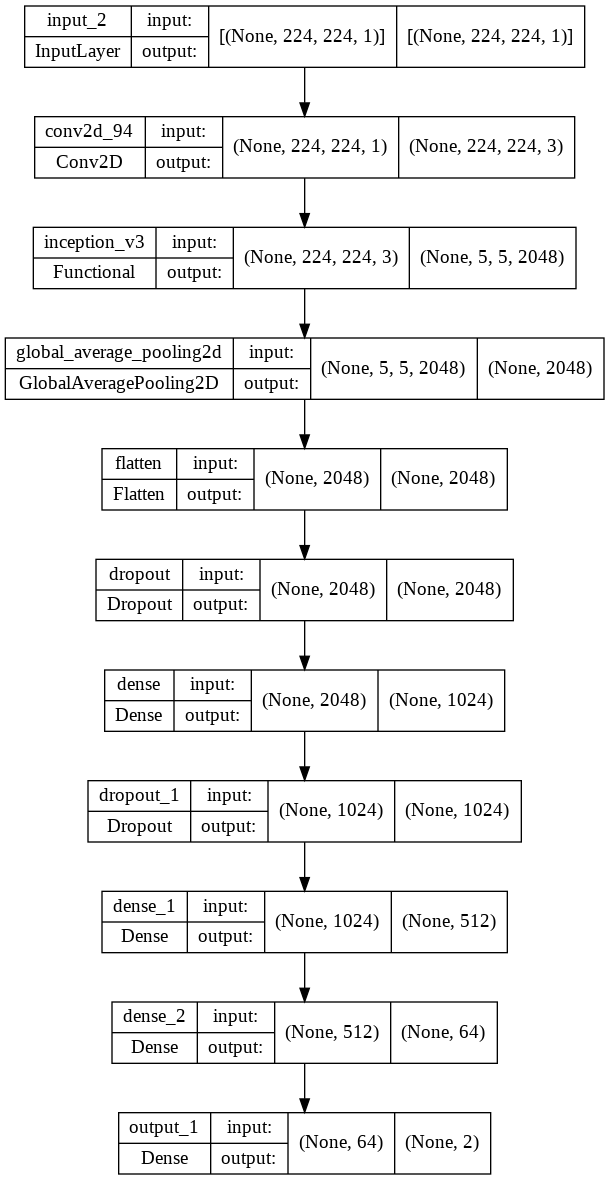

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='InceptionV3_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_name='InceptionV3_imagenet_Covid_pos_vs_neg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

#### Prediction

In [ ]:
print("Model VGG 16 Exp 1 Part C")
model = get_model_VGG16_gray()
#model.load_weights(log_dir+"Saved_models/"+model_name+".h5")
model.load_weights(W_dir+"1 C/"+model_name+".h5")

Model VGG 16 Exp 1 Part C
58900480/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

Accuracy: 0.827210593763349
F1 score: 0.8235660527728692
Recall: 0.827210593763349
Precision: 0.8218212810986205

 clasification report:
               precision    recall  f1-score   support

           0       0.69      0.61      0.65      1228
           1       0.87      0.90      0.89      3454

    accuracy                           0.83      4682
   macro avg       0.78      0.76      0.77      4682
weighted avg       0.82      0.83      0.82      4682


 confusion matrix:
 [[ 751  477]
 [ 332 3122]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,751,3122,332,477,0.854,0.262,0.612,0.904,0.693,0.867,0.882,0.65,0.5
Covid,3122,751,477,332,0.802,0.738,0.904,0.612,0.867,0.693,0.882,0.885,0.5


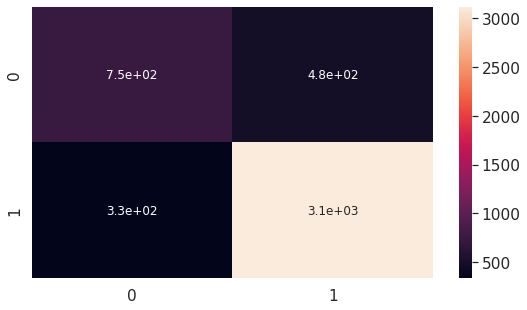

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

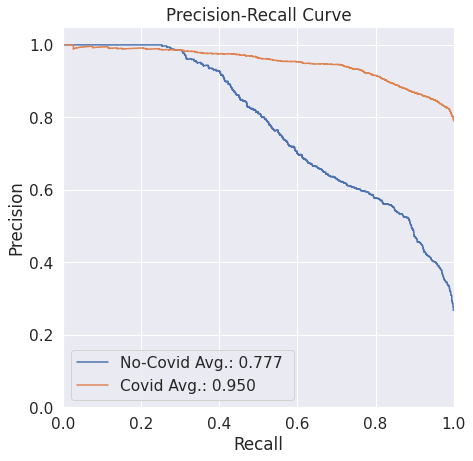

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg')

In [ ]:
print("Model VGG 19 Exp 1 Part C")
model = get_model_VGG19_gray()
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg')

In [ ]:
print("Model Inception V3 Exp 1 Part C")
model = get_model_InceptionV3()
#model.load_weights(log_dir+"Saved_models/"+model_name+".h5")
model.load_weights(W_dir+"1 C/"+model_name+".h5")

Model Inception V3 Exp 1 Part C
87924736/87910968 [==============================] - 4s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)        

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

Accuracy: 0.9376334899615549
F1 score: 0.9370854044211591
Recall: 0.9376334899615549
Precision: 0.936986365289965

 clasification report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      1228
           1       0.95      0.97      0.96      3454

    accuracy                           0.94      4682
   macro avg       0.93      0.91      0.92      4682
weighted avg       0.94      0.94      0.94      4682


 confusion matrix:
 [[1050  178]
 [ 114 3340]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,1050,3340,114,178,0.951,0.262,0.855,0.967,0.902,0.949,0.97,0.878,0.5
Covid,3340,1050,178,114,0.925,0.738,0.967,0.855,0.949,0.902,0.97,0.958,0.5


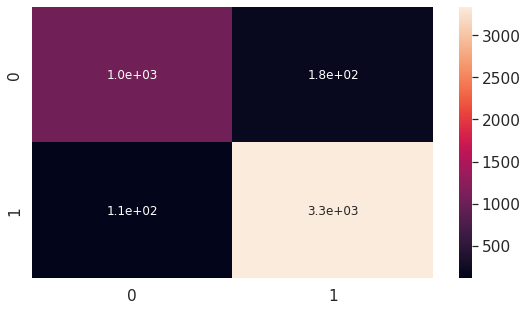

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

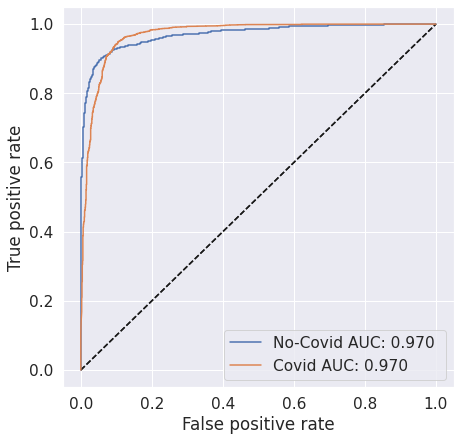

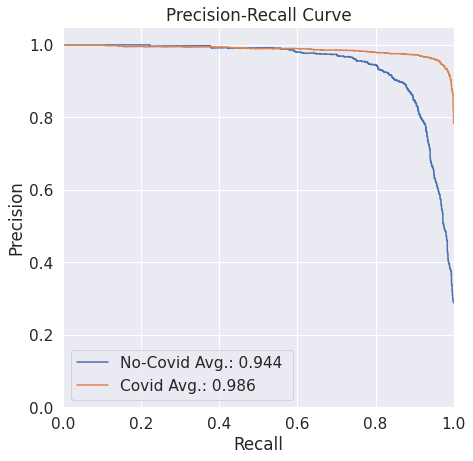

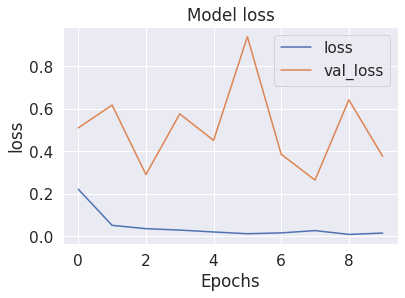

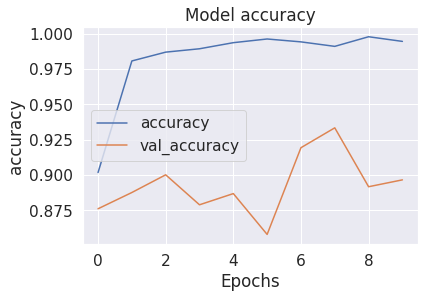

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'InceptionV3_imagenet_Covid_pos_vs_neg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'InceptionV3_imagenet_Covid_pos_vs_neg')

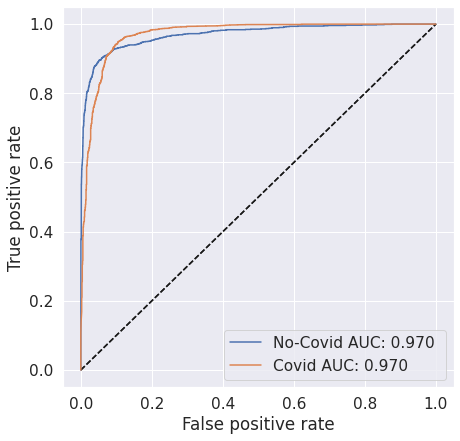

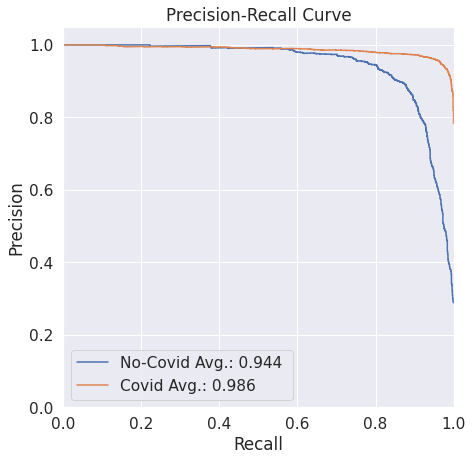

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg',curve='prc')

In [ ]:
models = [
{
    'label': 'VGG 16',
    'name' : 'VGG16_imagenet_Covid_pos_vs_neg',
    'model': get_model_VGG16_gray(),
},
{
    'label': 'VGG 19',
    'name' : 'VGG19_imagenet_Covid_pos_vs_neg',
    'model': get_model_VGG19_gray(),
},
{
    'label': 'Inception V3',
    'name' : 'InceptionV3_imagenet_Covid_pos_vs_neg',
    'model': get_model_InceptionV3(),
}
]


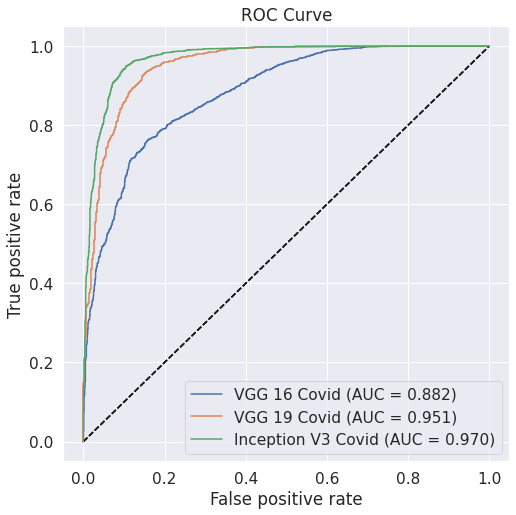

In [ ]:
get_ROC(models, "/content/drive/MyDrive/weights/1 C/", X_test, y_test, "1c")

In [ ]:
get_PRC(models, "/content/drive/MyDrive/weights/1 C/", X_test, y_test, "1c")

###Part D

In [ ]:
D_dir = '/Segmented'

In [ ]:
#To save memory
#Do direct min-max scaling after this
'''
X_train = np.load(P_dir + D_dir + '/X_pos_Seg_Train.npy')
X_test = np.load(P_dir + D_dir + '/X_pos_Seg_Test.npy')
X_dev = np.load(P_dir + D_dir + '/X_pos_Seg_Dev.npy')
a=len(X_train)
b=len(X_dev)
c=len(X_test)

y_train = np.load(N1_dir + D_dir + '/X_neg_Seg_Train.npy')
y_test = np.load(N1_dir + D_dir + '/X_neg_Seg_Test.npy')
y_dev = np.load(N1_dir + D_dir + '/X_neg_Seg_Dev.npy')
d=len(y_train)
e=len(y_dev)
f=len(y_test)

X_train=np.concatenate((y_train,X_train))
X_dev=np.concatenate((y_dev,X_dev))
X_test=np.concatenate((y_test,X_test))

y_train=np.concatenate((np.array([[1,0]]*d),np.array([[0,1]]*a)))
y_dev=np.concatenate((np.array([[1,0]]*e),np.array([[0,1]]*b)))
y_test=np.concatenate((np.array([[1,0]]*f),np.array([[0,1]]*c)))
'''

In [ ]:
X_train_P = np.load(P_dir + D_dir + '/X_pos_Seg_Train.npy')
X_test_P = np.load(P_dir + D_dir + '/X_pos_Seg_Test.npy')
X_dev_P = np.load(P_dir + D_dir + '/X_pos_Seg_Dev.npy')

In [ ]:
X_train_N = np.load(N1_dir + D_dir + '/X_neg_Seg_Train.npy')
X_test_N = np.load(N1_dir + D_dir + '/X_neg_Seg_Test.npy')
X_dev_N = np.load(N1_dir + D_dir + '/X_neg_Seg_Dev.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="/content/results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

Getting Base Model


NameError: ignored

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

Epoch 1/10
  1/138 [..............................] - ETA: 4:44:25 - loss: 0.9507 - accuracy: 0.6875

KeyboardInterrupt: ignored

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_InceptionV3()

Getting Base Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                          

In [ ]:
model_name='InceptionV3_imagenet_Covid_pos_vs_neg_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

Epoch 1/10
138/138 [==============================] - 100s 578ms/step - loss: 0.3183 - accuracy: 0.8437 - val_loss: 0.2934 - val_accuracy: 0.8817
Epoch 2/10
138/138 [==============================] - 71s 518ms/step - loss: 0.1311 - accuracy: 0.9501 - val_loss: 0.2617 - val_accuracy: 0.8968
Epoch 3/10
138/138 [==============================] - 72s 524ms/step - loss: 0.0767 - accuracy: 0.9707 - val_loss: 0.2946 - val_accuracy: 0.8968
Epoch 4/10
138/138 [==============================] - 74s 536ms/step - loss: 0.0684 - accuracy: 0.9760 - val_loss: 0.2655 - val_accuracy: 0.9208
Epoch 5/10
138/138 [==============================] - 73s 528ms/step - loss: 0.0480 - accuracy: 0.9831 - val_loss: 0.3410 - val_accuracy: 0.9052
Epoch 6/10
138/138 [==============================] - 74s 536ms/step - loss: 0.0447 - accuracy: 0.9866 - val_loss: 0.2383 - val_accuracy: 0.9282
Epoch 7/10
138/138 [==============================] - 73s 528ms/step - loss: 0.0326 - accuracy: 0.9897 - val_loss: 0.2796 - val_a

#### Prediction

In [ ]:
print("Model VGG 16 Exp 1 Part D")
model = get_model_VGG16_gray()
#model.load_weights(E1_dir+D_dir+'/VGG16_imagenet_posyneg_seg.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

Model VGG 16 Exp 1 Part D
58900480/58889256 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None

ValueError: ignored

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg_seg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg_seg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg_seg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg_seg')

In [ ]:
print("Model VGG 19 Exp 1 Part D")
model = get_model_VGG19_gray()
#model.load_weights(E1_dir+D_dir+'/VGG19_imagenet_posyneg_seg.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_seg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg_seg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg_seg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg_seg')

In [ ]:
print("Model Inception V3 Exp 1 Part D")
model = get_model_InceptionV3()
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

Model Inception V3 Exp 1 Part D
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_189 (Conv2D)         (None, 224, 224, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                           

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

Accuracy: 0.930158052114481
F1 score: 0.9311597685472132
Recall: 0.930158052114481
Precision: 0.9335732319739023

 clasification report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      1228
           1       0.97      0.94      0.95      3454

    accuracy                           0.93      4682
   macro avg       0.90      0.93      0.91      4682
weighted avg       0.93      0.93      0.93      4682


 confusion matrix:
 [[1124  104]
 [ 223 3231]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,1124,3231,223,104,0.907,0.262,0.915,0.935,0.834,0.969,0.975,0.873,0.5
Covid,3231,1124,104,223,0.954,0.738,0.935,0.915,0.969,0.834,0.975,0.952,0.5


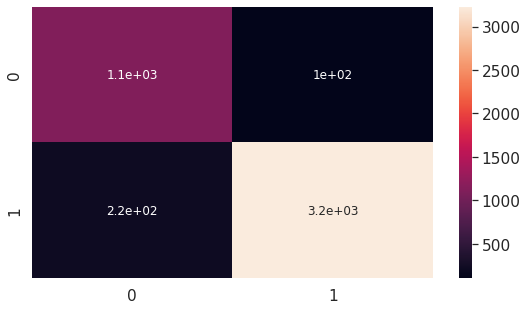

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

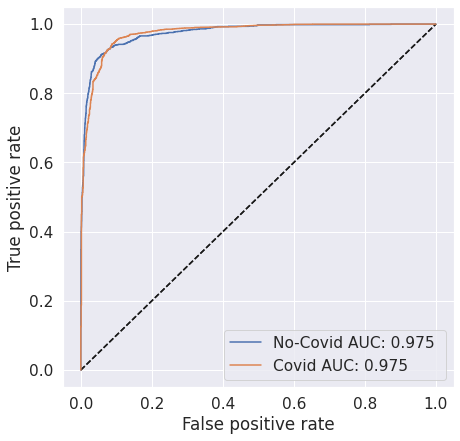

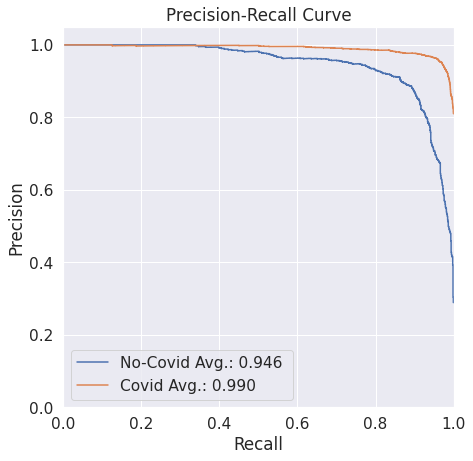

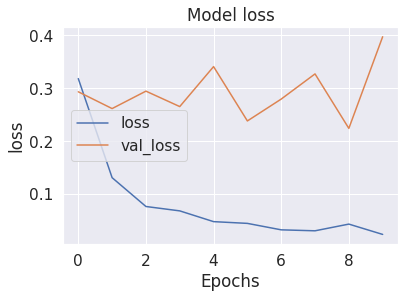

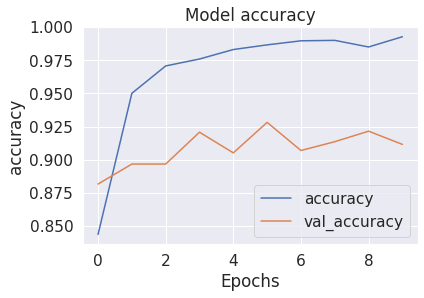

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg_seg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg_seg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'InceptionV3_imagenet_Covid_pos_vs_neg_seg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'InceptionV3_imagenet_Covid_pos_vs_neg_seg')

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_1994 (Conv2D)        (None, 224, 224, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_21  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_21 (Flatten)        (None, 2048)              0         
                                                                 
 dropout_42 (Dropout)        (None, 2048)              0         
                                                          

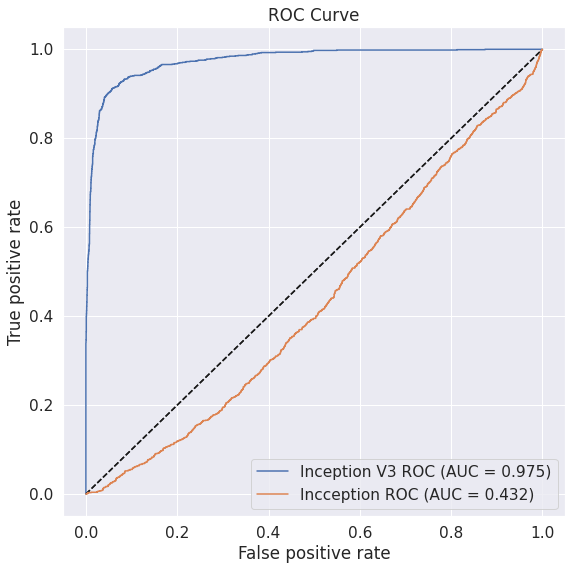

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt


models = [
{
    'label': 'Inception V3',
    'name' : 'InceptionV3_imagenet_Covid_pos_vs_neg_seg',
    'model': get_model_InceptionV3(),
},
{
    'label': 'Incception',
    'name' : 'InceptionV3_imagenet_Covid_pos_vs_neg',
    'model': get_model_InceptionV3(),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    #model.fit(x_train, y_train) # train the model
    model.load_weights(log_dir+"Saved_models/"+m['name']+".h5")
    y_pred=model.predict(X_test) # predict the test data
    curve_function = roc_curve
    auc_roc = roc_auc_score(y_test[:, 1], y_pred[:, 1])
    label = '%s ROC (AUC = %0.3f)' % (m['label'], auc_roc)
    xlabel = "False positive rate"
    ylabel = "True positive rate"
    a, b, _ = curve_function(y_test[:, 1], y_pred[:, 1])
    plt.figure(1, figsize=(9, 9))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(a, b, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("ROC Curve")
    plt.legend()
    #plt.show() 
plt.show()  


##Experiment 2

###Part C

In [ ]:
C_dir = '/Normal'

In [ ]:
X_train_P = np.load(P_dir + C_dir + '/X_pos_train_C.npy')
X_test_P = np.load(P_dir + C_dir + '/X_pos_test_C.npy')
X_dev_P = np.load(P_dir + C_dir + '/X_pos_dev_C.npy')

In [ ]:
X_train_N = np.load(N2_dir + C_dir + '/X_neg_Train_CC.npy')
X_test_N = np.load(N2_dir + C_dir + '/X_neg_Test_CC.npy')
X_dev_N = np.load(N2_dir + C_dir + '/X_neg_Dev_CC.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="/content/results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg2'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

Getting Base Model
80150528/80134624 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 224_input (InputLayer)      [(None, 224, 224, 1)]     0         
                                                                 
 224_block1_conv1 (Conv2D)   (None, 224, 224, 64)      640       
                                                                 
 224_block1_conv2 (Conv2D)   (None, 224, 224, 64)      36928     
                                                                 
 224_block1_pool (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 224_block2_conv1 (Conv2D)   (None, 112, 112, 128)     73856     
                                                                 
 224_block2_conv2 (Conv2D)   (None, 112, 

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg2'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

Epoch 1/10
  2/127 [..............................] - ETA: 5:22:33 - loss: 0.7781 - accuracy: 0.5938

#### Prediction

In [ ]:
print("Model VGG 16 Exp 2 Part C")
model = get_model_VGG16_gray()
#model.load_weights(E2_dir+C_dir+'/VGG16_imagenet_posyneg_normal_C.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg2')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg2')

In [ ]:
print("Model VGG 19 Exp 2 Part C")
model = get_model_VGG19_gray()
#model.load_weights(E2_dir+C_dir+'/VGG19_imagenet_posyneg_normal_C.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg2')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg2')

###Part D

In [ ]:
D_dir = '/Segmented'

In [ ]:
X_train_P = np.load(P_dir + D_dir + '/X_pos_Seg_Train.npy')
X_test_P = np.load(P_dir + D_dir + '/X_pos_Seg_Test.npy')
X_dev_P = np.load(P_dir + D_dir + '/X_pos_Seg_Dev.npy')

In [ ]:
X_train_N = np.load(N2_dir + D_dir + '/X_neg_Seg_Train_2.npy')
X_test_N = np.load(N2_dir + D_dir + '/X_neg_Seg_Test_2.npy')
X_dev_N = np.load(N2_dir + D_dir + '/X_neg_Seg_Dev_2.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

#### Train Models (GPU) 

In [ ]:
log_dir="/content/results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg2_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg2_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

#### Prediction

In [ ]:
print("Model VGG 16 Exp 2 Part D")
model = get_model_VGG16_gray()
#model.load_weights(E2_dir+D_dir+'/VGG16_imagenet_posyneg_seg_C.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2_seg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg2_seg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg2_seg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg2_seg')

In [ ]:
print("Model VGG 19 Exp 2 Part D")
model = get_model_VGG19_gray()
#model.load_weights(E2_dir+D_dir+'/VGG19_imagenet_posyneg_seg_C.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2_seg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg2_seg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg2_seg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg2_seg')

##Experiment 3

###Part C

In [ ]:
C_dir = '/Normal'

In [ ]:
X_train_P = np.load(P_dir + C_dir + '/X_pos_train_C.npy')
X_test_P = np.load(P_dir + C_dir + '/X_pos_test_C.npy')
X_dev_P = np.load(P_dir + C_dir + '/X_pos_dev_C.npy')

In [ ]:
X_train_N = np.load(N3_dir + C_dir + '/X_train_COVID_neg2.npy')
X_test_N = np.load(N3_dir + C_dir + '/X_test_COVID_neg2.npy')
X_dev_N = np.load(N3_dir + C_dir + '/X_dev_COVID_neg2.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

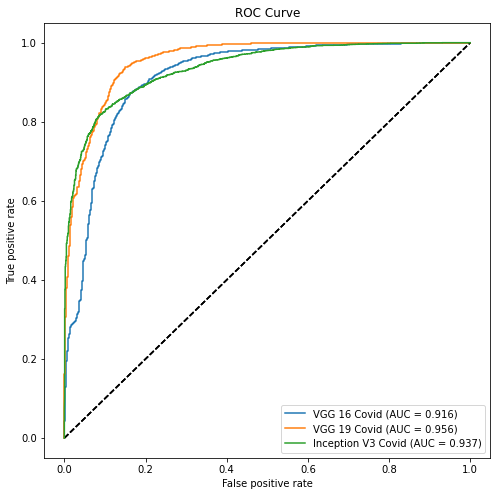

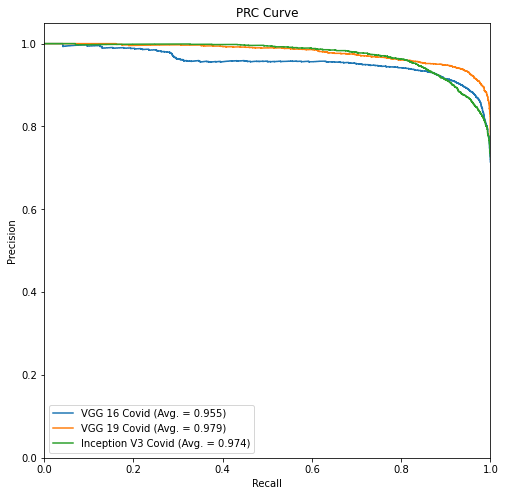

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt


models = [
{
    'label': 'VGG 16',
    'name' : 'VGG16_imagenet_Covid_pos_vs_neg3',
    'model': get_model_VGG16_gray(),
},
{
    'label': 'VGG 19',
    'name' : 'VGG19_imagenet_Covid_pos_vs_neg3',
    'model': get_model_VGG19_gray(),
},
{
    'label': 'Inception V3',
    'name' : 'InceptionV3_imagenet_Covid_pos_vs_neg3',
    'model': get_model_InceptionV3(),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    #model.fit(x_train, y_train) # train the model
    model.load_weights("/content/drive/MyDrive/model_weights/"+m['name']+".h5")
    y_pred=model.predict(X_test) # predict the test data
    curve_function = roc_curve
    auc_roc = roc_auc_score(y_test[:, 1], y_pred[:, 1])
    label = '%s Covid (AUC = %0.3f)' % (m['label'], auc_roc)
    xlabel = "False positive rate"
    ylabel = "True positive rate"
    a, b, _ = curve_function(y_test[:, 1], y_pred[:, 1])
    plt.figure(1, figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(a, b, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("ROC Curve")
    plt.legend()
    #plt.show() 
plt.savefig("Exp 3 c ROC.png",format='png',bbox_inches="tight") 
plt.show()
 


for m in models:
    model = m['model'] # select the model
    #model.fit(x_train, y_train) # train the model
    model.load_weights("/content/drive/MyDrive/model_weights/"+m['name']+".h5")
    y_pred=model.predict(X_test) # predict the test data
    precision, recall, _ = precision_recall_curve(y_test[:, 1], y_pred[:, 1])
    average_precision = average_precision_score(y_test[:, 1], y_pred[:, 1])
    label = '%s Covid (Avg. = %0.3f)' % (m['label'], average_precision)
    xlabel = "Recall"
    ylabel = "Precision"
    plt.figure(1, figsize=(8, 8))
    plt.step(recall, precision, where='post', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("PRC Curve")
    plt.legend()
    #plt.show() 
plt.savefig("Exp 3 c PRC.png",format='png',bbox_inches="tight")
plt.show()



#### Train Models (GPU) 

In [ ]:
log_dir="/content/results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg3'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg3'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_InceptionV3()

Getting Base Model
87924736/87910968 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)  

In [ ]:
model_name='InceptionV3_imagenet_Covid_pos_vs_neg3'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

Epoch 1/10
145/145 [==============================] - 208s 1s/step - loss: 0.2174 - accuracy: 0.9058 - val_loss: 0.7644 - val_accuracy: 0.7438
Epoch 2/10
145/145 [==============================] - 173s 1s/step - loss: 0.0560 - accuracy: 0.9796 - val_loss: 0.5743 - val_accuracy: 0.8105
Epoch 3/10
145/145 [==============================] - 173s 1s/step - loss: 0.0308 - accuracy: 0.9897 - val_loss: 0.5421 - val_accuracy: 0.8579
Epoch 4/10
145/145 [==============================] - 173s 1s/step - loss: 0.0196 - accuracy: 0.9931 - val_loss: 0.4672 - val_accuracy: 0.8656
Epoch 5/10
145/145 [==============================] - 172s 1s/step - loss: 0.0266 - accuracy: 0.9902 - val_loss: 1.9669 - val_accuracy: 0.7308
Epoch 6/10
145/145 [==============================] - 172s 1s/step - loss: 0.0146 - accuracy: 0.9961 - val_loss: 1.0337 - val_accuracy: 0.7924
Epoch 7/10
145/145 [==============================] - 172s 1s/step - loss: 0.0123 - accuracy: 0.9964 - val_loss: 1.6419 - val_accuracy: 0.7508

#### Prediction

In [ ]:
print("Model VGG 16 Exp 3 Part C")
model = get_model_VGG16_gray()
#model.load_weights(E3_dir+C_dir+'/VGG16_imagenet_posypre_normal.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3',)
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg3')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg3')

In [ ]:
print("Model VGG 19 Exp 3 Part C")
model = get_model_VGG19_gray()
#model.load_weights(E3_dir+C_dir+'/VGG19_imagenet_posypre_normal.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg3')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg3')

In [ ]:
print("Model Inception V3 Exp 3 Part C")
model = get_model_InceptionV3()
#model.load_weights(E3_dir+C_dir+'/VGG19_imagenet_posypre_normal.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

Model Inception V3 Exp 3 Part C
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_189 (Conv2D)         (None, 224, 224, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                           

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

Accuracy: 0.8659114315139032
F1 score: 0.8672492283207188
Recall: 0.8659114315139032
Precision: 0.8694129753315155

 clasification report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.78      1401
           1       0.92      0.89      0.90      3454

    accuracy                           0.87      4855
   macro avg       0.83      0.85      0.84      4855
weighted avg       0.87      0.87      0.87      4855


 confusion matrix:
 [[1126  275]
 [ 376 3078]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,1126,3078,376,275,0.848,0.289,0.804,0.891,0.75,0.918,0.937,0.776,0.5
Covid,3078,1126,275,376,0.884,0.711,0.891,0.804,0.918,0.75,0.937,0.904,0.5


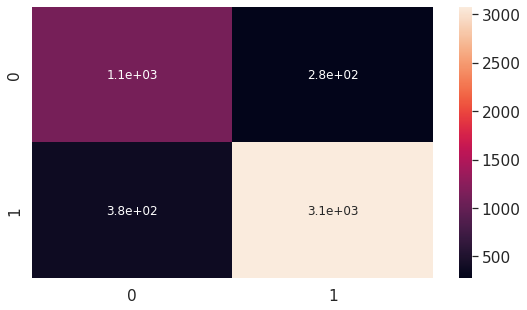

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg3')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

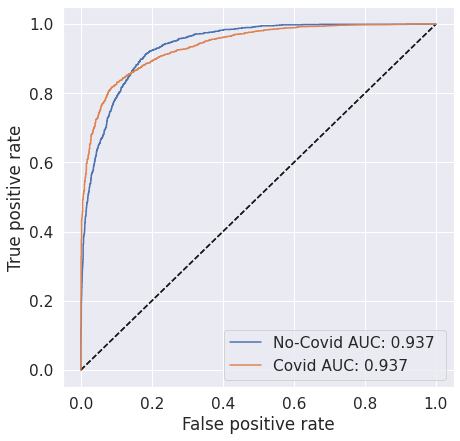

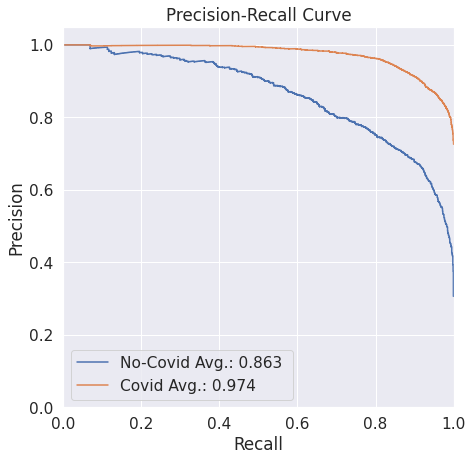

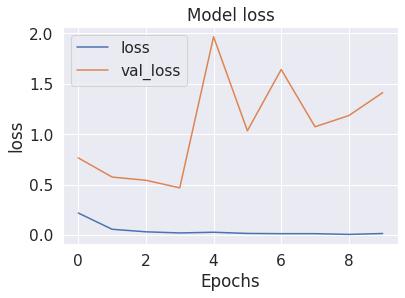

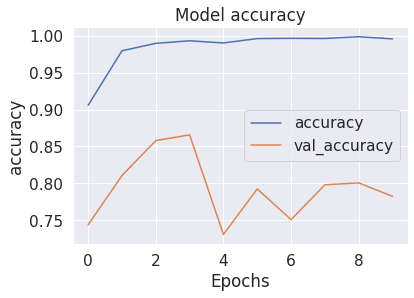

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg3',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg3',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'InceptionV3_imagenet_Covid_pos_vs_neg3')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'InceptionV3_imagenet_Covid_pos_vs_neg3')

###Part D

In [ ]:
D_dir = '/Segmented'

In [ ]:
#After this cell, directly do min-max scaling
X_train = np.load(P_dir + D_dir + '/X_pos_Seg_Train.npy')
X_test = np.load(P_dir + D_dir + '/X_pos_Seg_Test.npy')
X_dev = np.load(P_dir + D_dir + '/X_pos_Seg_Dev.npy')
a=len(X_train)
b=len(X_dev)
c=len(X_test)

y_train = np.load(N3_dir + D_dir + '/X_preC_Seg_Train.npy')
y_test = np.load(N3_dir + D_dir + '/X_preC_Seg_Test.npy')
y_dev = np.load(N3_dir + D_dir + '/X_preC_Seg_Dev.npy')
d=len(y_train)
e=len(y_dev)
f=len(y_test)

X_train=np.concatenate((y_train,X_train))
X_dev=np.concatenate((y_dev,X_dev))
X_test=np.concatenate((y_test,X_test))

y_train=np.concatenate((np.array([[1,0]]*d),np.array([[0,1]]*a)))
y_dev=np.concatenate((np.array([[1,0]]*e),np.array([[0,1]]*b)))
y_test=np.concatenate((np.array([[1,0]]*f),np.array([[0,1]]*c)))

In [ ]:
X_train_P = np.load(P_dir + D_dir + '/X_pos_Seg_Train.npy')
X_test_P = np.load(P_dir + D_dir + '/X_pos_Seg_Test.npy')
X_dev_P = np.load(P_dir + D_dir + '/X_pos_Seg_Dev.npy')

In [ ]:
X_train_N = np.load(N3_dir + D_dir + '/X_preC_Seg_Train.npy')
X_test_N = np.load(N3_dir + D_dir + '/X_preC_Seg_Test.npy')
X_dev_N = np.load(N3_dir + D_dir + '/X_preC_Seg_Dev.npy')

In [ ]:
X_train=np.concatenate((X_train_N,X_train_P))
X_dev=np.concatenate((X_dev_N,X_dev_P))
X_test=np.concatenate((X_test_N,X_test_P))

In [ ]:
y_train_N=np.array([[1,0]]*len(X_train_N))
y_dev_N=np.array([[1,0]]*len(X_dev_N))
y_test_N=np.array([[1,0]]*len(X_test_N))

y_train_P=np.array([[0,1]]*len(X_train_P))
y_dev_P=np.array([[0,1]]*len(X_dev_P))
y_test_P=np.array([[0,1]]*len(X_test_P))

In [ ]:
y_train=np.concatenate((y_train_N,y_train_P))
y_dev=np.concatenate((y_dev_N,y_dev_P))
y_test=np.concatenate((y_test_N,y_test_P))

In [ ]:
#Min_max scaled
X_train,y_train=min_max_preprocessing(X_train,y_train)
X_dev,y_dev=min_max_preprocessing(X_dev,y_dev)
X_test,y_test=min_max_preprocessing(X_test,y_test)

In [ ]:
X_train = np.float32(X_train)
X_dev = np.float32(X_dev)
X_test = np.float32(X_test)

In [ ]:
#std normalization
X_train,y_train,mean,std=samplewise_preprocessing(X_train,y_train)

In [ ]:
X_dev=featurewise_preprocessing(X_dev,mean,std)
X_test=featurewise_preprocessing(X_test,mean,std)

In [ ]:
def ROC_PRC(models, weight_path, X_test, y_test, file_name):
    for m in models:
        model = m['model'] 
        model.load_weights(weight_path+m['name']+".h5")
        y_pred=model.predict(X_test)
        curve_function = roc_curve
        auc_roc = roc_auc_score(y_test[:, 1], y_pred[:, 1])
        label = '%s Covid (AUC = %0.3f)' % (m['label'], auc_roc)
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(y_test[:, 1], y_pred[:, 1])
        plt.figure(1, figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title("ROC Curve")
        plt.legend()
    plt.savefig("Exp_"+file_name+"_ROC.png",format='png',bbox_inches="tight") 
    plt.show()
 


    for m in models:
        model = m['model'] 
        model.load_weights(weight_path+m['name']+".h5")
        y_pred=model.predict(X_test)
        precision, recall, _ = precision_recall_curve(y_test[:, 1], y_pred[:, 1])
        average_precision = average_precision_score(y_test[:, 1], y_pred[:, 1])
        label = '%s Covid (Avg. = %0.3f)' % (m['label'], average_precision)
        xlabel = "Recall"
        ylabel = "Precision"
        plt.figure(1, figsize=(8, 8))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title("PRC Curve")
        plt.legend()
    plt.savefig("Exp_"+file_name+"_PRC.png",format='png',bbox_inches="tight")
    plt.show()


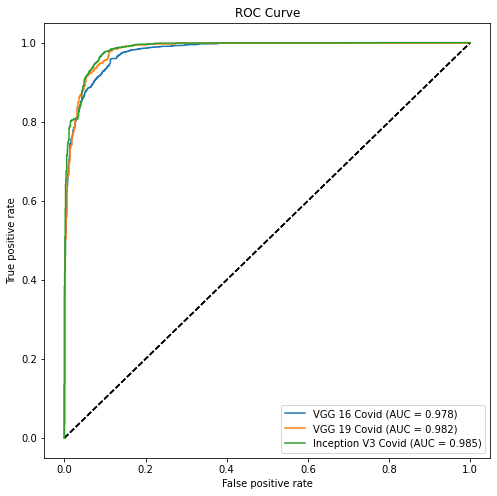

In [ ]:

models = [
{
    'label': 'VGG 16',
    'name' : 'VGG16_imagenet_Covid_pos_vs_neg3_seg',
    'model': get_model_VGG16_gray(),
},
{
    'label': 'VGG 19',
    'name' : 'VGG19_imagenet_Covid_pos_vs_neg3_seg',
    'model': get_model_VGG19_gray(),
},
{
    'label': 'Inception V3',
    'name' : 'InceptionV3_imagenet_Covid_pos_vs_neg3_seg',
    'model': get_model_InceptionV3(),
}
]

ROC_PRC(models, "/content/drive/MyDrive/model_weights/", X_test, y_test, "3d")


#### Train Models (GPU) 

In [ ]:
log_dir="/content/results/"

In [ ]:
class_weight= get_weight(np.argmax(y_train,axis=-1))

In [ ]:
print("Getting Base Model")
model = get_model_VGG16_gray()

In [ ]:
model_name='VGG16_imagenet_Covid_pos_vs_neg3_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_VGG19_gray()

In [ ]:
model_name='VGG19_imagenet_Covid_pos_vs_neg3_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

In [ ]:
print("Getting Base Model")
model = get_model_InceptionV3()

Getting Base Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_94 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                          

In [ ]:
model_name='InceptionV3_imagenet_Covid_pos_vs_neg3_seg'
filepath = log_dir+"Saved_models/"+model_name+".h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')
csv_logger = CSVLogger(log_dir +'csv/'+model_name+'.csv', append=True, separator=',')
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_dev, y_dev),class_weight=class_weight,callbacks=[csv_logger,checkpoint])

Epoch 1/10
145/145 [==============================] - 210s 1s/step - loss: 0.2357 - accuracy: 0.8973 - val_loss: 0.4010 - val_accuracy: 0.8862
Epoch 2/10
145/145 [==============================] - 174s 1s/step - loss: 0.0901 - accuracy: 0.9684 - val_loss: 0.1644 - val_accuracy: 0.9488
Epoch 3/10
145/145 [==============================] - 172s 1s/step - loss: 0.0567 - accuracy: 0.9801 - val_loss: 0.5358 - val_accuracy: 0.8620
Epoch 4/10
145/145 [==============================] - 172s 1s/step - loss: 0.0403 - accuracy: 0.9859 - val_loss: 0.2005 - val_accuracy: 0.9466
Epoch 5/10
145/145 [==============================] - 172s 1s/step - loss: 0.0318 - accuracy: 0.9880 - val_loss: 0.1965 - val_accuracy: 0.9466
Epoch 6/10
145/145 [==============================] - 172s 1s/step - loss: 0.0280 - accuracy: 0.9909 - val_loss: 0.2858 - val_accuracy: 0.9229
Epoch 7/10
145/145 [==============================] - 171s 1s/step - loss: 0.0427 - accuracy: 0.9858 - val_loss: 0.2382 - val_accuracy: 0.9256

#### Prediction

In [ ]:
print("Model VGG 16 Exp 3 Part D")
model = get_model_VGG16_gray()
#model.load_weights(E3_dir+D_dir+'/VGG16_imagenet_posypre_seg.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3_seg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG16_imagenet_Covid_pos_vs_neg3_seg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg3_seg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG16_imagenet_Covid_pos_vs_neg3_seg')

In [ ]:
print("Model VGG 19 Exp 3 Part D")
model = get_model_VGG19_gray()
#model.load_weights(E3_dir+D_dir+'/VGG19_imagenet_posypre_seg.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3_seg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'VGG19_imagenet_Covid_pos_vs_neg3_seg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg3_seg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'VGG19_imagenet_Covid_pos_vs_neg3_seg')

In [ ]:
print("Model Inception V3 Exp 3 Part D")
model = get_model_InceptionV3()
#model.load_weights(E3_dir+D_dir+'/VGG19_imagenet_posypre_seg.h5')
model.load_weights(log_dir+"Saved_models/"+model_name+".h5")

Model Inception V3 Exp 3 Part D
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_189 (Conv2D)         (None, 224, 224, 3)       30        
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                           

In [ ]:
predictions=model.predict(X_test)
y_pred_bool = np.argmax(predictions, axis=-1)
y_hat=np.argmax(y_test,axis=-1)

Accuracy: 0.9501544799176107
F1 score: 0.9501012409790699
Recall: 0.9501544799176107
Precision: 0.9500576331445467

 clasification report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91      1401
           1       0.96      0.97      0.97      3454

    accuracy                           0.95      4855
   macro avg       0.94      0.94      0.94      4855
weighted avg       0.95      0.95      0.95      4855


 confusion matrix:
 [[1275  126]
 [ 116 3338]]


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
No-Covid,1275,3338,116,126,0.952,0.289,0.91,0.966,0.917,0.964,0.985,0.913,0.5
Covid,3338,1275,126,116,0.948,0.711,0.966,0.91,0.964,0.917,0.985,0.965,0.5


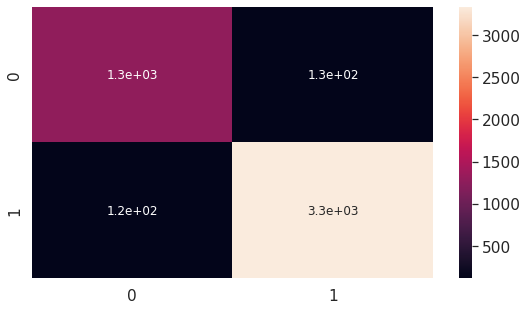

In [ ]:
metrics(y_hat,y_pred_bool,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg3_seg')
labels = ["No-Covid","Covid"]
get_performance_metrics(y_test,predictions,labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

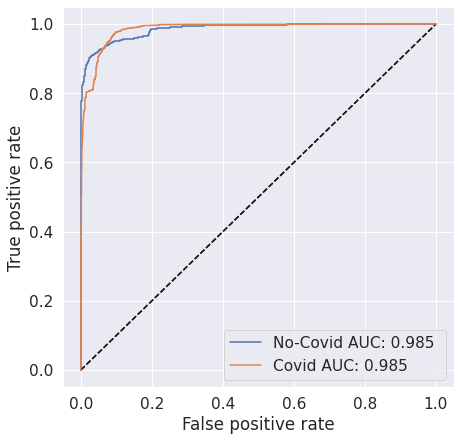

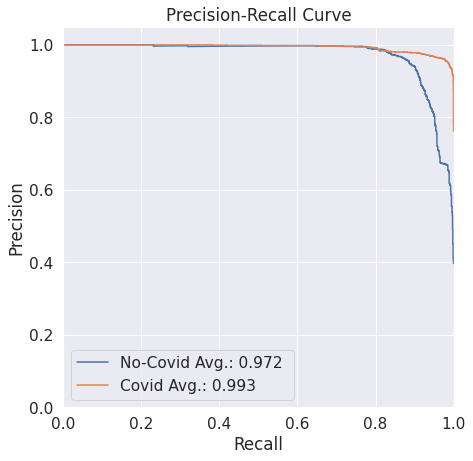

AttributeError: ignored

In [ ]:
#ROC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg3_seg',curve='roc')

#PRC_CURVE 
get_curve(y_test,predictions,labels,log_dir,'InceptionV3_imagenet_Covid_pos_vs_neg3_seg',curve='prc')

#Loss graph
plot_graphs(history,'loss', log_dir, 'InceptionV3_imagenet_Covid_pos_vs_neg3_seg')

#Accuracy graph
plot_graphs(history,'accuracy', log_dir, 'InceptionV3_imagenet_Covid_pos_vs_neg3_seg')

In [ ]:

%cp -av "/content/results/Saved_models/InceptionV3_imagenet_Covid_pos_vs_neg3_seg.h5" "/content/drive/MyDrive/"

'/content/results/Saved_models/InceptionV3_imagenet_Covid_pos_vs_neg3_seg.h5' -> '/content/drive/MyDrive/InceptionV3_imagenet_Covid_pos_vs_neg3_seg.h5'


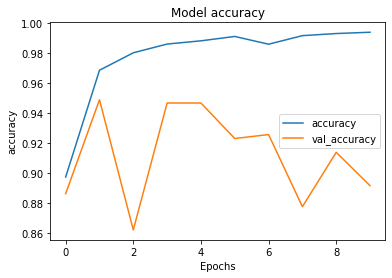

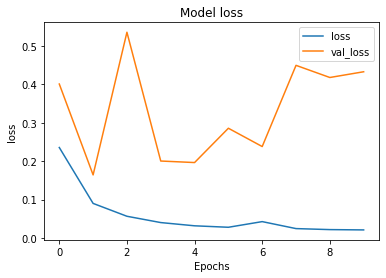

In [ ]:
plot_by_csv('accuracy', log_dir, model_name)
plot_by_csv('loss', log_dir, model_name)